### Making training dataset

1. bring on chemical and physical soil variables (*harmonized to 0-30cm per profile via mass preserving spline, mode, and categorical majority*)

2. extract vectors (soil type, lithology) per profile/sample site
3. extract rasters (bioclimatic, ecosystem type and DEM/terrain) per profile/sample site
4. merge into one training dataset by profile (or site_id)


In [6]:
## Load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load tables ===
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)


# Subset analyses, keep all morpho columns
analyses_subset = analyses.copy()
morpho_subset = morpho.copy()

# Filter only profiles present in site_info
valid_profiles = usable_sites['profile'].dropna().unique()
analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho_subset[morpho_subset['profile'].isin(valid_profiles)]

# Ensure merge keys have same dtype
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)

# === 5. Merge analyses and morpho ===
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'morpho_id'],
    how='inner',
    suffixes=('', '_morpho')
)

combined_data.head()

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_3342/3803634425.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_3342/3803634425.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)


,lab_sample_id,analysis_id,morpho_id,sample_id,profile,soil_biology_id,eg,thick_sand,fine_sand,silt,...,dry_chroma,moist_color_name,moist_hue,moist_value,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature
0,458,Bg_113/57_4_1,Bg_113/57_4_1,5040,113_57,,59.0,42.9,13.1,10.9,...,6.0,,,,,,,,,
1,894,Bg_253/57_4_1,Bg_253/57_4_1,5456,253_57,,NaN,NaN,0.0,0.0,...,7.0,,,,,Irregularmente pouco compacto e medianamente c...,"Muito firme (com alguns torroes da mesma cor, ...",,Raro,Saibro quartzoso e de gres
2,7,B_109/62_1_1,B_109/62_1_1,11011,109_62,,1.0,15.3,48.5,17.6,...,2.0,Pardo-avermelhado,5YR,4.0,3.0,Pequena,Brando e brando a ligeiramente duro,,,
3,1549,Cb_20/59_3_1,Cb_20/59_3_1,7277,20_59,,NaN,NaN,NaN,NaN,...,6.0,Pardo-avermelhado,5YR,4.0,4.0,,,,,
4,5965,Mj_27/63_3_1,Mj_27/63_3_1,13391,27_63,,NaN,NaN,NaN,NaN,...,6.0,Laranja a pardo-avermelhado-escuro,5YR,4.0,6.0,Media a grande,Ligeiramente duro,,,


In [7]:
# === 6. Join with usable_sites ===
merged_final = pd.merge(
    combined_data,
    usable_sites,
    on='profile',
    how='inner'
)

# === 7. Optionally merge 'year' from samples ===
if 'sample_id' in samples.columns and 'year' in samples.columns:
    merged_final = pd.merge(
        merged_final,
        samples[['sample_id', 'year']],
        on='sample_id',
        how='left'
    )

merged_final.head()

,lab_sample_id,analysis_id,morpho_id,sample_id,profile,soil_biology_id,eg,thick_sand,fine_sand,silt,...,site_info_id,X_coord,Y_coord,district,geo_features_id,climate_id,topo_id,soil_type_id,geom,year
0,458,Bg_113/57_4_1,Bg_113/57_4_1,5040,113_57,,59.0,42.9,13.1,10.9,...,2400,14.624539,-13.315070,Benguela,197,197,197,112,0101000020E6100000000000A0C33F2D40000000E050A1...,1957.0
1,894,Bg_253/57_4_1,Bg_253/57_4_1,5456,253_57,,NaN,NaN,0.0,0.0,...,2045,15.001662,-12.341700,Benguela,1945,1945,1945,1194,0101000020E6100000000000E0D9002E4000000040F3AE...,1957.0
2,7,B_109/62_1_1,B_109/62_1_1,11011,109_62,,1.0,15.3,48.5,17.6,...,2523,16.778372,-13.896562,Bie,137,137,137,76,0101000020E61000000000006043C73040000000200ACB...,1962.0
3,1549,Cb_20/59_3_1,Cb_20/59_3_1,7277,20_59,,NaN,NaN,NaN,NaN,...,33,12.553629,-4.762017,Cabinda,1288,1288,1288,789,0101000020E610000000000040751B2940000000404E0C...,1959.0
4,5965,Mj_27/63_3_1,Mj_27/63_3_1,13391,27_63,,NaN,NaN,NaN,NaN,...,1060,17.135303,-9.595469,Malanje,2105,2105,2105,1289,0101000020E610000000000040A322314000000060E130...,1963.0


In [8]:
# List of columns to drop
cols_to_drop = [
    'geo_features_id',
    'climate_id',
    'topo_id',
    'soil_type_id',
    'geom',
    'field_sample_code',  
    'depth',
    'al',
    'si',
    'p',
    's',
    'cl',
    'ti',
    'cr',
    'mn',
    'fe',
    'co',
    'ni',
    'cu',
    'zn',
    'arsenic',
    'se',
    'rb',
    'sr',
    'zr',
    'nb',
    'mo',
    'cd',
    'sn',
    'sb',
    'ba',
    'ta',
    'w',
    'pt',
    'au',
    'hg',
    'tl',
    'pb',
    'bi',
    'th',
    'u'
]

# Drop these columns if they exist in the DataFrame
merged_final = merged_final.drop(columns=[col for col in cols_to_drop if col in merged_final.columns])

# Check the remaining columns
list(merged_final.columns)

['lab_sample_id',
 'analysis_id',
 'morpho_id',
 'sample_id',
 'profile',
 'soil_biology_id',
 'eg',
 'thick_sand',
 'fine_sand',
 'silt',
 'clay',
 'eq_hum',
 'atm_1/3',
 'atm_15',
 'caco3',
 'gypsum',
 'free_iron',
 'organic_carbon',
 'total_n',
 'p205',
 'organic_material',
 'ph_h2o',
 'ph_kcl',
 'Ca++',
 'Mg++',
 'Na+',
 'K+',
 'exchangable_bases_sum',
 'cec',
 'v',
 'conductivity',
 'soluble_sodium',
 'Min_<0,002',
 'Min_0,05-0,02',
 'Min_0,2-0,05',
 'Min_2-0,2',
 'porosity',
 'bulk_density',
 'sample_depth',
 'sample_id_morpho',
 'horizon_layer',
 'upper_depth',
 'lower_depth',
 'moisture_degree',
 'root_quantity',
 'root_diameter',
 'texture',
 'structure_type',
 'structure_class',
 'structure_degree',
 'pore_diameter',
 'pore_quantity',
 'pore_shape',
 'dry_color_name',
 'dry_hue',
 'dry_value',
 'dry_chroma',
 'moist_color_name',
 'moist_hue',
 'moist_value',
 'moist_chroma',
 'compaction',
 'durability',
 'friability',
 'thick_contents_count',
 'thick_contents_nature',
 'site

In [16]:
# Count unique years per profile
year_counts = merged_final.groupby('profile')['year'].nunique()

# Profiles with more than 1 year
multi_year_profiles = year_counts[year_counts > 1]

print(f"Number of profiles with multiple years: {len(multi_year_profiles)}")
print("Profiles with multiple years:")
print(multi_year_profiles)


Number of profiles with multiple years: 1
Profiles with multiple years:
profile
101A_58    2
Name: year, dtype: int64


In [9]:
## harmonize chem and physical samples to 1 depth (0-30)

import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from collections import Counter

# ------------------------------
# 1) Mass-preserving spline function (robust)
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        # One horizon → just return the value
        return values[0]
    elif n == 2:
        # Two horizons → thickness-weighted average
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # For 3+ horizons → spline
    midpoints = (depth_top + depth_bottom)/2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    # Ensure spline order fits number of points
    k = min(3, len(values)-1)
    if k < 1:
        return np.nan
    
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# 2) Identify variable types
# ------------------------------
drop_cols = [
    'lab_sample_id','analysis_id','morpho_id','sample_id','sample_id_morpho',
    'site_info_id','X_coord','Y_coord','profile',
    'upper_depth','lower_depth','sample_depth'
]

numeric_cols = merged_final.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in drop_cols]

categorical_cols = merged_final.select_dtypes(include=['object','category']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in drop_cols]

# ------------------------------
# 3) Create harmonized dataset per profile
# ------------------------------
profiles = merged_final['profile'].unique()
harmonized_list = []

for pid in profiles:
    profile = merged_final[merged_final['profile'] == pid].copy()
    if profile.empty:
        continue
    
    profile_harmonized = {'profile': pid}
    
    # Numeric variables
    for col in numeric_cols:
        if col in ['organic_carbon','total_n','bulk_density']:
            profile_harmonized[col] = fit_mpspline(
                depth_top=profile['upper_depth'],
                depth_bottom=profile['lower_depth'],
                values=profile[col],
                lam=1.0,
                target_depths=[0,30]
            )
        else:
            thickness = profile['lower_depth'] - profile['upper_depth']
            valid_mask = ~profile[col].isna() & ~thickness.isna()
            if valid_mask.sum() > 0:
                profile_harmonized[col] = np.average(
                    profile[col][valid_mask], 
                    weights=thickness[valid_mask]
                )
            else:
                profile_harmonized[col] = np.nan
    
    # Categorical variables → mode
    for col in categorical_cols:
        vals = profile[col].dropna()
        if not vals.empty:
            profile_harmonized[col] = vals.mode().iloc[0]
        else:
            profile_harmonized[col] = np.nan
    
    # Metadata
    meta_cols = ['X_coord','Y_coord','district','year']
    for col in meta_cols:
        if col in profile.columns:
            profile_harmonized[col] = profile[col].iloc[0]
    
    harmonized_list.append(profile_harmonized)

# ------------------------------
# 4) Convert to DataFrame
# ------------------------------
profile_0_30cm = pd.DataFrame(harmonized_list)

print(f"Shape: {profile_0_30cm.shape} (profiles x variables)")


Shape: (1488, 62) (profiles x variables)


In [33]:
profile_0_30cm.head()

,profile,eg,thick_sand,fine_sand,silt,clay,eq_hum,atm_15,free_iron,organic_carbon,...,moist_value,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature,district,X_coord,Y_coord
0,113_57,31.933333,46.273684,15.352632,9.594737,28.800000,17.318182,NaN,1.646364,0.784545,...,,,,,,,,Benguela,14.624539,-13.315070
1,253_57,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,,,Irregularmente pouco compacto e medianamente c...,"Muito firme (com alguns torroes da mesma cor, ...",,Raro,Saibro quartzoso e de gres,Benguela,15.001662,-12.341700
2,109_62,11.200000,12.862500,37.752500,20.930000,28.447500,21.197500,9.4,2.283750,0.451160,...,4.0,6.0,Media,,,,,Bie,16.778372,-13.896562
3,20_59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,Cabinda,12.553629,-4.762017
4,27_63,NaN,1.000000,45.318261,7.532174,46.117391,NaN,NaN,NaN,NaN,...,4.0,6.0,Media a grande,,,,,Malanje,17.135303,-9.595469


In [11]:
## check for outliers
numeric_cols = profile_0_30cm.select_dtypes(include=['float64', 'int64']).columns
profile_0_30cm[numeric_cols].describe()

,eg,thick_sand,fine_sand,silt,clay,eq_hum,atm_15,free_iron,organic_carbon,p205,...,ph_h2o,ph_kcl,cec,soluble_sodium,porosity,bulk_density,horizon_layer,year,X_coord,Y_coord
count,819.000000,1438.000000,1450.000000,1446.000000,1445.000000,1066.000000,478.000000,978.000000,1233.000000,526.000000,...,1360.000000,1209.000000,1235.000000,1227.000000,1488.000000,1487.000000,1488.000000,1274.000000,1488.000000,1488.000000
mean,6.086450,29.218056,36.648085,7.317365,26.256121,12.501382,9.915138,1.602113,0.718194,0.124339,...,5.898064,4.846155,7.610288,0.933537,0.423485,1.140367,3.646022,1960.639717,15.497314,-10.695359
std,9.316355,19.684165,16.722597,7.015074,16.778631,10.448523,6.683102,2.272195,0.639172,0.429092,...,0.974123,0.863677,8.174857,4.898481,0.133817,0.377852,0.868425,3.213242,2.843668,3.263291
min,0.000000,0.123158,0.000000,0.000000,0.000000,-17.445455,-24.909091,0.010000,0.000000,0.010000,...,4.072432,3.500000,-33.628182,-3.542857,0.000000,-3.643750,1.000000,1946.000000,0.000000,-17.998255
25%,1.000000,12.046369,23.331793,2.442059,12.832500,3.111412,4.209969,0.472642,0.336918,0.040000,...,5.230870,4.267273,3.433697,0.000000,0.389902,1.070749,3.000000,1958.000000,13.955428,-12.935900
50%,2.557971,27.894206,34.880827,5.189422,24.181685,11.865909,9.496753,1.041201,0.568332,0.055967,...,5.639433,4.574627,5.410457,0.000000,0.449357,1.215843,3.685875,1961.000000,15.361887,-10.837213
75%,6.272882,44.146705,47.978814,9.717221,37.410959,19.857065,13.950725,2.035959,0.901806,0.080586,...,6.218127,5.156364,9.026706,0.000000,0.490625,1.342391,4.235345,1963.000000,16.832141,-8.799642
max,61.000000,89.694118,88.894118,48.675000,82.800000,56.355882,29.000000,52.366667,7.581768,6.100000,...,9.400000,8.660000,171.124500,64.857143,2.650000,2.591714,6.772358,1967.000000,23.962458,0.000000


In [12]:
#IQR method
Q1 = profile_0_30cm[numeric_cols].quantile(0.25)
Q3 = profile_0_30cm[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((profile_0_30cm[numeric_cols] < (Q1 - 1.5 * IQR)) | 
            (profile_0_30cm[numeric_cols] > (Q3 + 1.5 * IQR)))


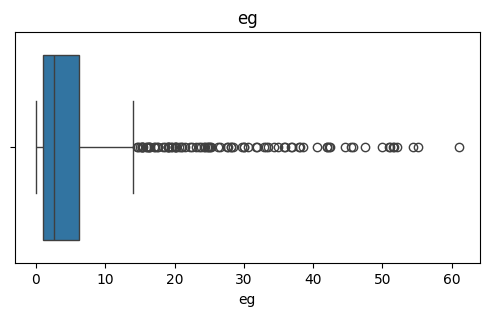

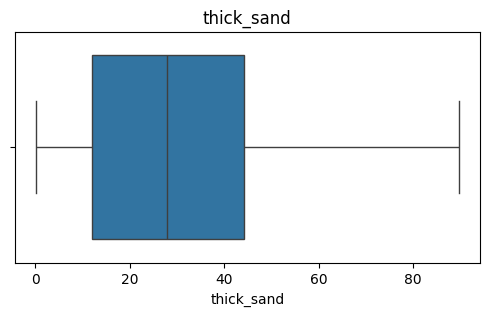

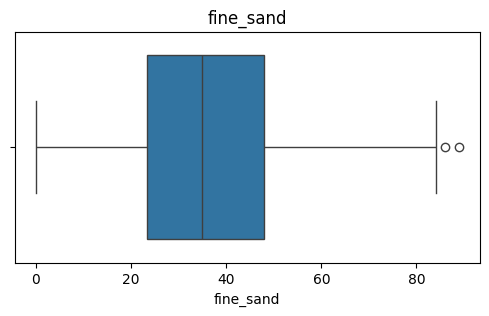

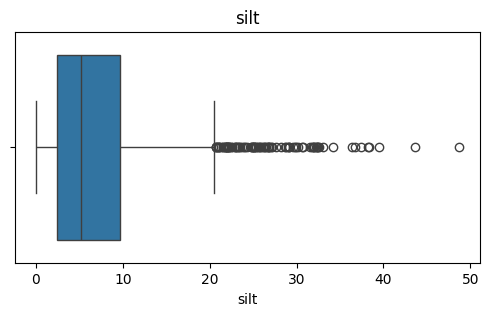

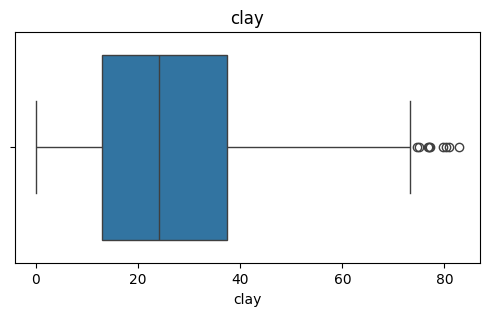

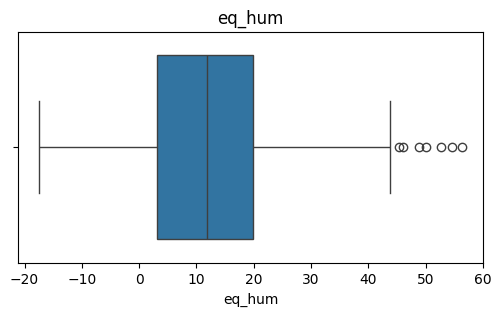

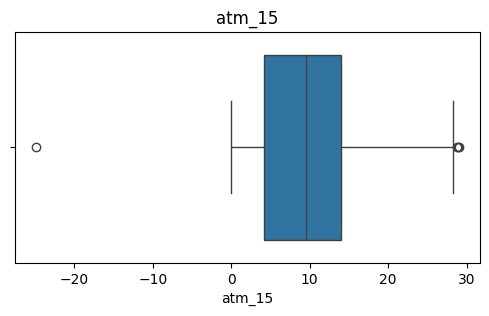

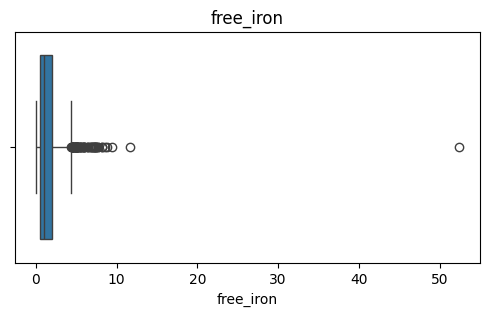

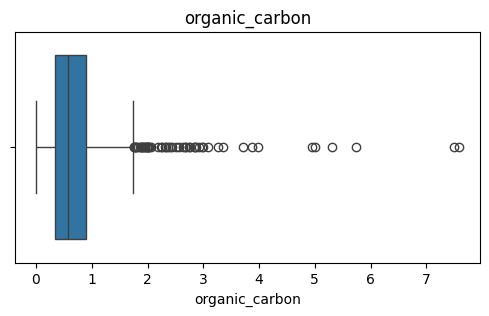

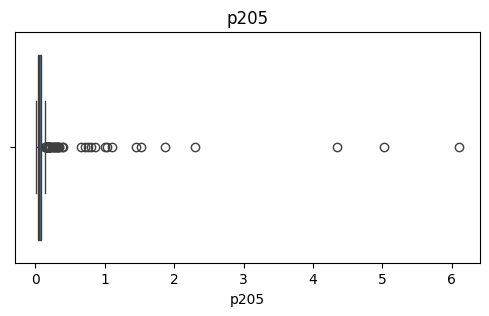

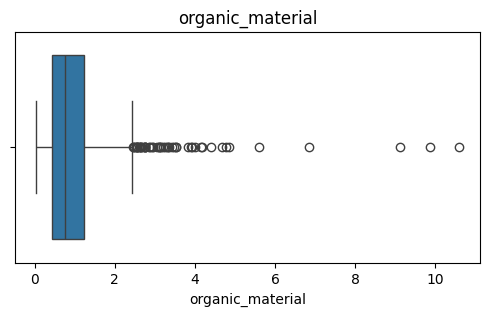

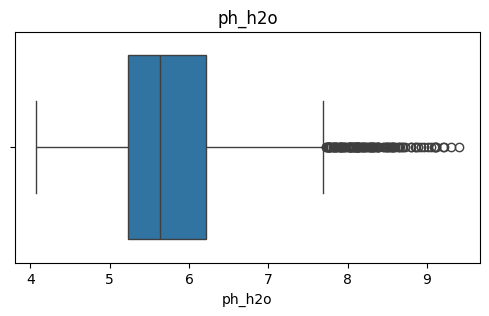

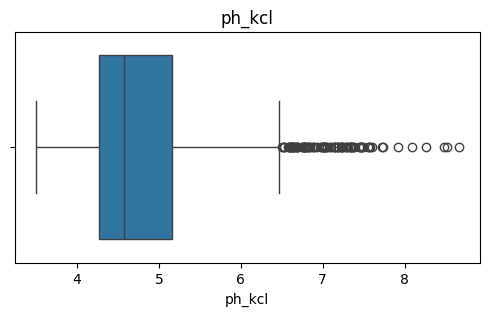

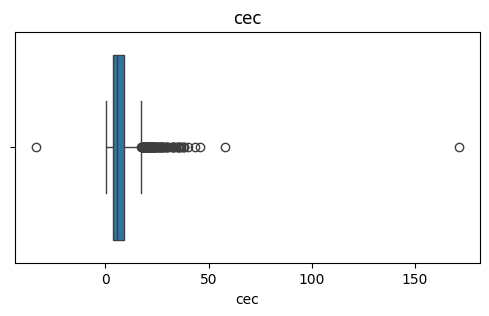

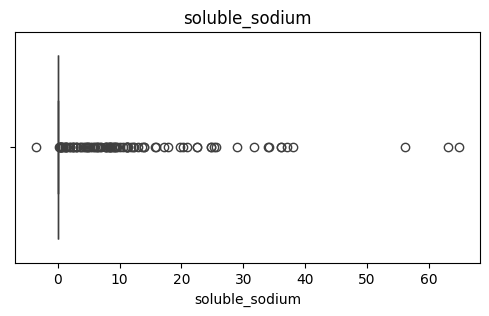

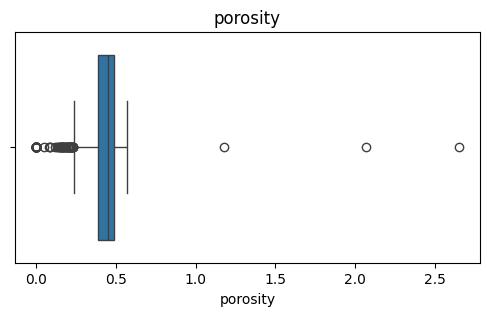

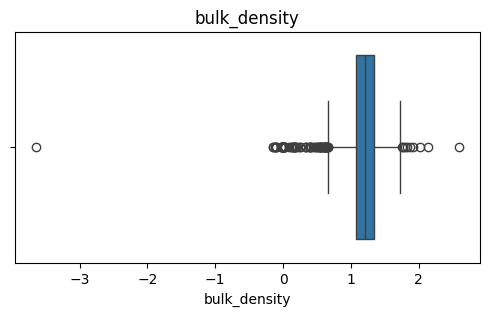

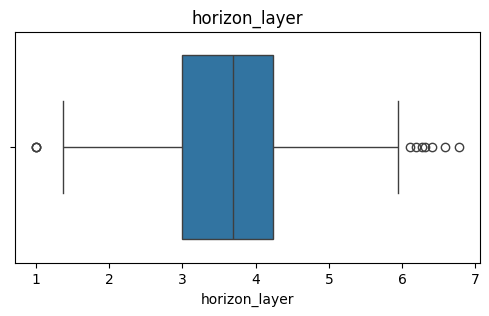

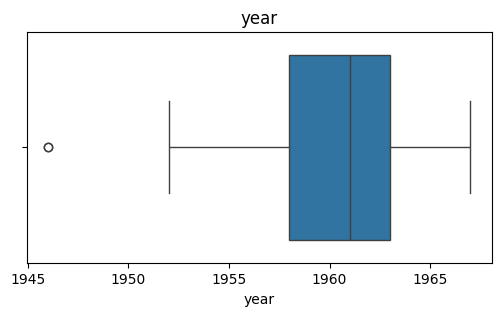

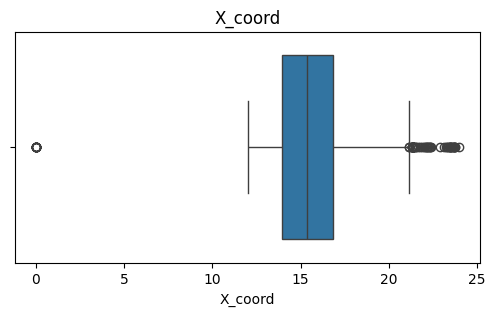

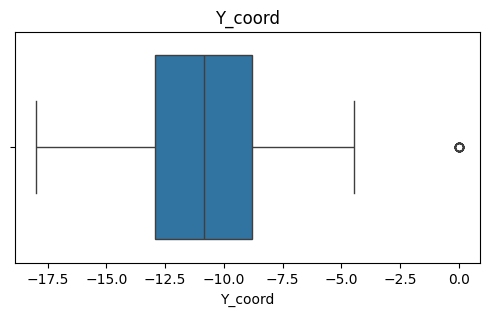

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=profile_0_30cm[col])
    plt.title(col)
    plt.show()


In [15]:
import pandas as pd

# Select only numeric columns
numeric_cols = profile_0_30cm.select_dtypes(include=['float64', 'int64']).columns

# Calculate Q1, Q3 and IQR
Q1 = profile_0_30cm[numeric_cols].quantile(0.25)
Q3 = profile_0_30cm[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Loop through each numeric column and find outliers
outlier_dict = {}

for col in numeric_cols:
    outlier_rows = profile_0_30cm[(profile_0_30cm[col] < (Q1[col] - 1.5 * IQR[col])) |
                                   (profile_0_30cm[col] > (Q3[col] + 1.5 * IQR[col]))]
    if not outlier_rows.empty:
        outlier_dict[col] = outlier_rows.index.tolist()

# Print summary
for col, rows in outlier_dict.items():
    print(f"Column '{col}' has {len(rows)} outlier(s) in rows: {rows}")

# Optional: create a dataframe of all outlier rows
#all_outliers = profile_0_30cm.loc[set(sum(outlier_dict.values(), []))]


Column 'eg' has 88 outlier(s) in rows: [0, 113, 120, 122, 124, 127, 128, 137, 176, 186, 190, 197, 199, 201, 202, 205, 208, 210, 211, 214, 217, 219, 224, 228, 231, 236, 241, 242, 243, 244, 249, 258, 306, 309, 371, 379, 415, 468, 476, 491, 495, 496, 514, 525, 552, 573, 575, 613, 710, 716, 724, 725, 726, 728, 729, 730, 735, 748, 749, 791, 801, 829, 830, 832, 860, 865, 878, 882, 977, 1030, 1071, 1104, 1207, 1298, 1299, 1302, 1303, 1307, 1311, 1317, 1319, 1321, 1328, 1335, 1391, 1436, 1477, 1485]
Column 'fine_sand' has 2 outlier(s) in rows: [890, 1031]
Column 'silt' has 90 outlier(s) in rows: [2, 20, 126, 138, 141, 142, 143, 144, 150, 153, 158, 164, 170, 194, 248, 253, 275, 352, 354, 356, 363, 364, 447, 488, 493, 494, 508, 509, 511, 512, 517, 518, 527, 529, 538, 539, 558, 560, 574, 577, 586, 597, 602, 610, 665, 823, 855, 856, 860, 926, 996, 1006, 1035, 1051, 1055, 1078, 1147, 1158, 1162, 1169, 1173, 1175, 1182, 1186, 1191, 1194, 1203, 1209, 1210, 1215, 1218, 1221, 1222, 1226, 1227, 1230, 12

## Extract soil data and lithology from .tif to csv per profile

In [37]:
import geopandas as gpd
import pandas as pd
import os
import re  # for regex

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
soil_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/angola_soil_data2_32733.gpkg"
lithology_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/lithology2.gpkg"


# --- Load data ---
points = gpd.read_file(points_path)
soil = gpd.read_file(soil_path)[["FAOSOIL", "DOMSOI", "faosoil_id", "geometry"]]
lithology = gpd.read_file(lithology_path)[["africa_lithology_90m.img.vat_lithology", "geometry"]]

# --- Ensure CRS matches ---
if points.crs != soil.crs:
    soil = soil.to_crs(points.crs)
if points.crs != lithology.crs:
    lithology = lithology.to_crs(points.crs)

# --- Spatial join ---
points_soil = gpd.sjoin(points, soil, how="left", predicate="intersects")

# Drop index_right from first join
if "index_right" in points_soil.columns:
    points_soil = points_soil.drop(columns=["index_right"])

points_soil_lith = gpd.sjoin(points_soil, lithology, how="left", predicate="intersects")

# Drop index_right from second join
if "index_right" in points_soil_lith.columns:
    points_soil_lith = points_soil_lith.drop(columns=["index_right"])

# --- Remove numbers from lithology column ---
# Example: "1. Carbonate" → "Carbonate"
points_soil_lith["africa_lithology_90m.img.vat_lithology"] = points_soil_lith[
    "africa_lithology_90m.img.vat_lithology"
].apply(lambda x: re.sub(r"^\d+\.\s*", "", str(x)))

# Drop multiple columns
points_soil_lith_clean = points_soil_lith
points_soil_lith_clean = points_soil_lith_clean.drop(columns=["geo_features_id", "climate_id", "topo_id", "soil_type_id"])
points_soil_lith_clean = points_soil_lith_clean.drop(columns=["geometry"])

# --- Save clean CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_vector_clean.csv"
points_soil_lith_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)

✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_vector_clean.csv


In [38]:
points_soil_lith_clean.columns

Index(['site_info_id', 'profile', 'X_coord', 'Y_coord', 'district', 'FAOSOIL',
       'DOMSOI', 'faosoil_id', 'africa_lithology_90m.img.vat_lithology'],
      dtype='object')

In [40]:
# Count unique profiles
n_profiles1 = points_soil_lith_clean['profile'].nunique()
print(f"Unique profiles: {n_profiles1}")

Unique profiles: 1488


## Extract the landsurfaceforms raster values per profile

In [14]:
import rasterio
import geopandas as gpd
import pandas as pd

# --- Load your points ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
points = gpd.read_file(points_path)

# --- Load your raster ---
raster_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/landsurfaceforms/landsurfaceforms.tif"
raster = rasterio.open(raster_path)

# --- Ensure points are in the same CRS as the raster ---
if points.crs != raster.crs:
    points = points.to_crs(raster.crs)

# --- Extract raster values at point locations ---
coords = [(x, y) for x, y in zip(points.geometry.x, points.geometry.y)]
points['landsurface_value'] = [val[0] for val in raster.sample(coords)]

# --- Optional: convert codes to descriptive categories ---
landsurface_lookup = {
    1: "smooth_plains",
    2: "irregular_plains",
    3: "escarpments",
    4: "hills",
    5: "breaks",
    6: "low_mountains",
    7: "high_mountains/deep_canyons"
}
points['landsurface_label'] = points['landsurface_value'].map(landsurface_lookup)

# --- Define your working DataFrame ---
landsurface_points = points.copy()

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id"]
landsurface_points_clean = landsurface_points.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/landsurface_sample_points.csv"
landsurface_points_clean.drop(columns='geometry').to_csv(output_csv, index=False)

print("CSV saved at:", output_csv)


KeyError: "['geometry'] not found in axis"

In [13]:
print(f"Shape: {landsurface_points_clean.shape} (profiles x variables)")
landsurface_points_clean.head()

Shape: (1488, 8) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,geometry,landsurface_value,landsurface_label
0,2770,1_57,12.161278,-15.222598,Namibe,POINT (195025.855 8315068.542),1,smooth_plains
1,48,1_59,12.575774,-4.866985,Cabinda,POINT (231130.92 9461556.108),5,breaks
2,881,1_63,17.081955,-9.274587,Malanje,POINT (728708.838 8974120.144),2,irregular_plains
3,2675,10_54,14.445188,-14.922688,Huila,POINT (440331.329 8350150.683),1,smooth_plains
4,2698,10_55,13.455059,-14.977228,Huila,POINT (333872.184 8343613.735),2,irregular_plains


## extract the ecosystem raster values per profile

In [20]:
import rasterio
import geopandas as gpd
import pandas as pd
from dbfread import DBF

# --- Load your points ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
ecosystems_points = gpd.read_file(points_path)

# --- Load raster (ecosystem.tif) ---
ecosyst_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/labelled_ecosystems32733.tif"
raster = rasterio.open(ecosyst_path)

# --- Ensure CRS match ---
if ecosystems_points.crs != raster.crs:
    ecosystems_points = ecosystems_points.to_crs(raster.crs)

# --- Extract raster values (band 1) ---
coords = [(x, y) for x, y in zip(ecosystems_points.geometry.x, ecosystems_points.geometry.y)]
ecosystems_points['eco_value'] = [val[0] for val in raster.sample(coords)]

# --- Read the VAT (.dbf) ---
vat_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_raw/Africa Terrestrial Ecosystems/africa_labeledecosystems_90m/africa_labeledecosystems_90m.tif.vat.dbf"
vat_records = DBF(vat_path, load=True)
vat_df = pd.DataFrame(iter(vat_records))

# --- Build lookup tables ---
subclass_lookup = dict(zip(vat_df['Value'], vat_df['subclass']))
class_lookup    = dict(zip(vat_df['Value'], vat_df['class']))
division_lookup = dict(zip(vat_df['Value'], vat_df['Division']))

# --- Map values to labels ---
ecosystems_points['eco_subclass'] = ecosystems_points['eco_value'].map(subclass_lookup)
ecosystems_points['eco_class']    = ecosystems_points['eco_value'].map(class_lookup)
ecosystems_points['eco_division'] = ecosystems_points['eco_value'].map(division_lookup)

# --- Check for unmatched raster codes ---
unique_raster_vals = set(ecosystems_points['eco_value'].unique())
vat_vals = set(vat_df['Value'].unique())
missing = unique_raster_vals - vat_vals

print("Unique raster values in points:", sorted(unique_raster_vals))
print("Unique VAT values:", sorted(vat_vals)[:20], "...")
print("Missing values (in raster but not in VAT):", missing)

Unique raster values in points: [-2147483648, 0, 1, 3, 4, 66, 67, 89, 96, 97, 98, 113, 116, 118, 123, 143, 157, 200, 202, 204, 211, 216, 236, 246, 602]
Unique VAT values: [0, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 21, 27, 51, 52, 61] ...
Missing values (in raster but not in VAT): {-2147483648}
CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecosystem_w_points.csv


In [23]:
## Map numeric codes to labels

# --- Assume your DataFrame is called ecosystems_points ---

# 1) Clean the leading numeric codes
ecosystems_points['eco_subclass_clean'] = ecosystems_points['eco_subclass'].str.replace(r'^\S+\s+', '', regex=True)
ecosystems_points['eco_class_clean']    = ecosystems_points['eco_class'].str.replace(r'^\S+\s+', '', regex=True)
ecosystems_points['eco_division_clean'] = ecosystems_points['eco_division'].str.replace(r'^\S+\s+', '', regex=True)

# 2) Convert cleaned columns to categorical codes for modeling
ecosystems_points['eco_subclass_code'] = ecosystems_points['eco_subclass_clean'].astype('category').cat.codes
ecosystems_points['eco_class_code']    = ecosystems_points['eco_class_clean'].astype('category').cat.codes
ecosystems_points['eco_division_code'] = ecosystems_points['eco_division_clean'].astype('category').cat.codes

# 3) Optional: keep a mapping dictionary to decode later
subclass_mapping = dict(enumerate(ecosystems_points['eco_subclass_clean'].astype('category').cat.categories))
class_mapping    = dict(enumerate(ecosystems_points['eco_class_clean'].astype('category').cat.categories))
division_mapping = dict(enumerate(ecosystems_points['eco_division_clean'].astype('category').cat.categories))


,eco_subclass,eco_subclass_clean,eco_subclass_code,eco_class,eco_class_clean,eco_class_code,eco_division,eco_division_clean,eco_division_code
0,"3.A Warm Desert & Semi-Desert Woodland, Scrub ...","Warm Desert & Semi-Desert Woodland, Scrub & Gr...",5,3 Desert & Semi-Desert,Desert & Semi-Desert,1,3.A.2.Fi Namib-Gariep Desert,Namib-Gariep Desert,10
1,1.A Tropical Forest,Tropical Forest,3,1 Forest to Open Woodland,Forest to Open Woodland,2,1.A.2.Fd Guineo-Congolian Evergreen & Semi-Eve...,Guineo-Congolian Evergreen & Semi-Evergreen Ra...,5
2,"2.A Tropical Grassland, Savanna & Shrubland","Tropical Grassland, Savanna & Shrubland",4,2 Shrubland & Grassland,Shrubland & Grassland,3,2.A.1.Ff West-Central African Mesic Woodland &...,West-Central African Mesic Woodland & Savanna,15
3,"2.A Tropical Grassland, Savanna & Shrubland","Tropical Grassland, Savanna & Shrubland",4,2 Shrubland & Grassland,Shrubland & Grassland,3,2.A.1.Ff West-Central African Mesic Woodland &...,West-Central African Mesic Woodland & Savanna,15
4,"2.A Tropical Grassland, Savanna & Shrubland","Tropical Grassland, Savanna & Shrubland",4,2 Shrubland & Grassland,Shrubland & Grassland,3,2.A.1.Ff West-Central African Mesic Woodland &...,West-Central African Mesic Woodland & Savanna,15


In [28]:
# output: cleaned and coded categorical variables
# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
ecosystems_points_clean = ecosystems_points.drop(columns=drop_cols, errors="ignore")

# --- Save results including cleaned/coded ecosystem columns ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecosystem_w_points_clean.csv"
ecosystems_points_clean.to_csv(output_csv, index=False)

print("CSV saved at:", output_csv)


CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/ecosystem_w_points_clean.csv


## bioclimatic rasters to csv for each sample point

In [34]:
#### bioclimatic rasters to CSV for each sample point

import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
bioclimraster_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/bioclimatic32733/"

# --- Load point data ---
bioclim_perpoint = gpd.read_file(points_path)

# --- Get list of rasters (assuming .tif files) ---
bioclimraster_files = sorted(glob.glob(os.path.join(bioclimraster_folder, "*.tif")))

# --- Reproject points once (using first raster as reference) ---
if bioclimraster_files:
    with rasterio.open(bioclimraster_files[0]) as src_ref:
        if bioclim_perpoint.crs != src_ref.crs:
            bioclim_perpoint = bioclim_perpoint.to_crs(src_ref.crs)

# --- Extract raster values for each point ---
coords = [(x, y) for x, y in zip(bioclim_perpoint.geometry.x, bioclim_perpoint.geometry.y)]

for raster_path in bioclimraster_files:
    name = os.path.splitext(os.path.basename(raster_path))[0]  # e.g. bio1.tif → "bio1"
    with rasterio.open(raster_path) as src:
        values = []
        for val in src.sample(coords):
            # Handle NoData / masked values
            if val is None or np.isnan(val[0]):
                values.append(np.nan)
            else:
                values.append(val[0])
        bioclim_perpoint[name] = values

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
bioclim_perpoint_clean = bioclim_perpoint.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv"
bioclim_perpoint_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)


✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_bioclim1.csv


In [35]:
print(f"Shape: {bioclim_perpoint_clean.shape} (profiles x variables)")
bioclim_perpoint_clean.head()

Shape: (1488, 22) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,annual_mean_temp,annual_precip2,isothermality_32733,max_temp_warmest_month32733,mean_temp_driest_quarter32733,...,min_temp_coldest_month32733,precip_coldest_quarter32733,precip_driest_month32733,precip_driest_quarter32733,precip_seasonality2,precip_warmest_quarter32733,precip_wettest_month32733,precip_wettest_quarter32733,temp_annual_range32733,temp_seasonality32733
0,2770,1_57,12.161278,-15.222598,Namibe,20.692232,76,51.184036,28.283258,18.380421,...,12.9,1,0,0,101,47,24,50,15.400000,25.000542
1,48,1_59,12.575774,-4.866985,Cabinda,25.188669,1143,54.972408,31.293846,22.299763,...,17.9,3,0,3,79,525,196,525,13.382994,18.245573
2,881,1_63,17.081955,-9.274587,Malanje,21.685974,1369,72.330200,30.931761,21.163675,...,11.1,9,0,9,75,542,227,588,19.820923,4.635531
3,2675,10_54,14.445188,-14.922688,Huila,20.039265,895,58.460194,30.497786,15.942005,...,6.7,2,0,1,98,303,227,509,23.780096,27.048286
4,2698,10_55,13.455059,-14.977228,Huila,17.571049,815,66.047607,27.182159,15.377293,...,6.8,9,0,0,90,163,177,438,20.374357,17.226534


## terrain / DEM features to csv for each sample point

In [40]:
## terrain / DEM features to csv for each sample point

import rasterio
import geopandas as gpd
import pandas as pd
import glob
import os
import numpy as np

# --- Input paths ---
points_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/usable_site_info_epsg32733.gpkg"
terrain_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/DEM_characteristics"

# --- Load point data ---
DEM_perpoint = gpd.read_file(points_path)

# --- Get list of rasters (assuming .tif files) ---
terrain_files = sorted(glob.glob(os.path.join(terrain_folder, "*.tif")))

# --- Reproject points once (using first raster as reference) ---
if terrain_files:
    with rasterio.open(terrain_files[0]) as src_ref:
        if DEM_perpoint.crs != src_ref.crs:
            DEM_perpoint = DEM_perpoint.to_crs(src_ref.crs)

# --- Extract raster values for each point ---
coords = [(x, y) for x, y in zip(DEM_perpoint.geometry.x, DEM_perpoint.geometry.y)]

for raster_path in terrain_files:
    name = os.path.splitext(os.path.basename(raster_path))[0]  # e.g. slope.tif → "slope"
    with rasterio.open(raster_path) as src:
        values = []
        for val in src.sample(coords):
            if val is None or np.isnan(val[0]):
                values.append(np.nan)
            else:
                values.append(val[0])
        DEM_perpoint[name] = values
    print(f"✅ Extracted {name}")

# --- Add categorical labels for aspect_classes ---
if "aspect_classes" in DEM_perpoint.columns:
    aspect_lookup = {
        1: "N", 2: "NE", 3: "E", 4: "SE",
        5: "S", 6: "SW", 7: "W", 8: "NW"
    }
    DEM_perpoint["aspect_label"] = DEM_perpoint["aspect_classes"].map(aspect_lookup)

# --- Drop unnecessary columns ---
drop_cols = ["geo_features_id", "climate_id", "topo_id", "soil_type_id", "geometry"]
DEM_perpoint_clean = DEM_perpoint.drop(columns=drop_cols, errors="ignore")

# --- Save to CSV ---
output_csv = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv"
DEM_perpoint_clean.to_csv(output_csv, index=False)

print("✅ CSV saved at:", output_csv)

✅ Extracted MRVBF
✅ Extracted RLD
✅ Extracted aspect
✅ Extracted aspect_classes
✅ Extracted aspect_cos
✅ Extracted aspect_sin
✅ Extracted dem_filledfiltered
✅ Extracted flow_accumulation
✅ Extracted relief
✅ Extracted ridge_levels
✅ Extracted roughness
✅ Extracted slope
✅ Extracted twi_300m
✅ Extracted valleydepth2
✅ CSV saved at: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/tables/soil_samples_with_DEM.csv


In [41]:
print(f"Shape: {DEM_perpoint_clean.shape} (profiles x variables)")
DEM_perpoint_clean.head()

Shape: (1488, 20) (profiles x variables)


,site_info_id,profile,X_coord,Y_coord,district,MRVBF,RLD,aspect,aspect_classes,aspect_cos,aspect_sin,dem_filledfiltered,flow_accumulation,relief,ridge_levels,roughness,slope,twi_300m,valleydepth2,aspect_label
0,2770,1_57,12.161278,-15.222598,Namibe,2.708386,54.436230,102.856216,-3.402823e+38,-0.222505,0.974932,57.107746,1.311048e+06,7.927418,476.700043,7.927418,1.443425,25.065683,419.592285,NaN
1,48,1_59,12.575774,-4.866985,Cabinda,0.012611,84.676865,48.047207,-3.402823e+38,0.668518,0.743696,129.162643,1.295204e+05,54.121292,587.831604,54.121292,12.074688,19.629591,458.668945,NaN
2,881,1_63,17.081955,-9.274587,Malanje,0.011206,215.602356,56.015442,-3.402823e+38,0.558969,0.829188,1203.378052,9.378133e+04,30.569336,1203.378052,30.569336,1.931547,20.013874,0.000000,NaN
3,2675,10_54,14.445188,-14.922688,Huila,4.854465,57.767700,251.096680,-3.402823e+38,-0.323972,-0.946067,1316.670410,1.173250e+05,7.386475,1426.358887,7.386475,1.390512,21.794485,109.688477,NaN
4,2698,10_55,13.455059,-14.977228,Huila,0.864722,72.822266,207.937805,-3.402823e+38,-0.883457,-0.468513,2023.976685,1.469902e+05,18.864624,2084.300781,18.864624,0.890335,20.572569,60.324219,NaN


can delete part below -- its in script 'technical_check'

In [44]:
## setting resolution to 300m (the resolution that matches a majority of my covariates) 

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import glob
import os

# --- Input and output folders ---
input_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/DEM_characteristics/"
output_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/DEM_characteristics_300m/"

os.makedirs(output_folder, exist_ok=True)

# --- Target resolution ---
target_res = (300, 300)  # (xres, yres) in meters

# --- Loop through all .tif files ---
for raster_path in glob.glob(os.path.join(input_folder, "*.tif")):
    with rasterio.open(raster_path) as src:
        # Define target transform and metadata
        transform, width, height = calculate_default_transform(
            src.crs,
            src.crs,   # same CRS, just resampling
            src.width,
            src.height,
            *src.bounds,
            resolution=target_res
        )

        kwargs = src.meta.copy()
        kwargs.update({
            "crs": src.crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        # Output path
        out_path = os.path.join(output_folder, os.path.basename(raster_path))

        # Perform reprojection / resampling
        with rasterio.open(out_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=Resampling.average  # use bilinear for continuous, nearest for categorical
                )

        print(f"✅ Resampled {os.path.basename(raster_path)} → 300 m")

print("🎯 All rasters saved in:", output_folder)

✅ Resampled aspect_classes.tif → 300 m
✅ Resampled aspect.tif → 300 m
✅ Resampled MRVBF.tif → 300 m
✅ Resampled twi_300m.tif → 300 m
✅ Resampled slope.tif → 300 m
✅ Resampled dem_filledfiltered.tif → 300 m
✅ Resampled flow_accumulation.tif → 300 m
✅ Resampled valleydepth2.tif → 300 m
✅ Resampled ridge_levels.tif → 300 m
✅ Resampled aspect_sin.tif → 300 m
✅ Resampled aspect_cos.tif → 300 m
✅ Resampled RLD.tif → 300 m
✅ Resampled relief.tif → 300 m
✅ Resampled roughness.tif → 300 m
🎯 All rasters saved in: /Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/DEM_characteristics_300m/


In [46]:
import rasterio
import geopandas as gpd
import glob
import os

# --- Paths ---
bioclimraster_folder = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/bioclimatic32733/"
ecosyst_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/labelled_ecosystems32733.tif"
soil_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/angola_soil_data2_32733.gpkg"
lithology_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/lithology2.gpkg"
landsurface_path = "/Volumes/One_Touch/angola_soils_thesis/GIS_Angola/data_processed/landsurfaceforms/landsurfaceforms.tif"

print("📏 Checking raster resolutions...")

# --- Bioclimatic rasters ---
bioclim_files = sorted(glob.glob(os.path.join(bioclimraster_folder, "*.tif")))
for raster_path in bioclim_files:
    with rasterio.open(raster_path) as src:
        res_x, res_y = src.res
        print(f"Bioclim {os.path.basename(raster_path)} → {res_x:.2f} x {res_y:.2f}")

# --- Ecosystem raster ---
with rasterio.open(ecosyst_path) as src:
    res_x, res_y = src.res
    print(f"Ecosystem.tif → {res_x:.2f} x {res_y:.2f}")

# --- Landsurface raster ---
with rasterio.open(landsurface_path) as src:
    res_x, res_y = src.res
    print(f"Landsurfaceforms.tif → {res_x:.2f} x {res_y:.2f}")

print("\n🌍 Checking vector datasets (no true resolution)...")

# --- Soil vector ---
soil = gpd.read_file(soil_path)
print(f"Soil vector: {len(soil)} features, bounds = {soil.total_bounds}")

# --- Lithology vector ---
lith = gpd.read_file(lithology_path)
print(f"Lithology vector: {len(lith)} features, bounds = {lith.total_bounds}")


📏 Checking raster resolutions...
Bioclim annual_mean_temp.tif → 18355.02 x 18355.02
Bioclim annual_precip2.tif → 18355.02 x 18355.02
Bioclim isothermality_32733.tif → 18116.64 x 18141.59
Bioclim max_temp_warmest_month32733.tif → 18355.00 x 18355.00
Bioclim mean_temp_driest_quarter32733.tif → 18355.00 x 18355.00
Bioclim mean_temp_warmest_quarter32733.tif → 18355.00 x 18355.00
Bioclim mean_temp_wettest_quarter32733.tif → 18355.00 x 18355.00
Bioclim min_temp_coldest_month32733.tif → 18355.00 x 18355.00
Bioclim precip_coldest_quarter32733.tif → 18355.00 x 18355.00
Bioclim precip_driest_month32733.tif → 18355.00 x 18355.00
Bioclim precip_driest_quarter32733.tif → 18355.00 x 18355.00
Bioclim precip_seasonality2.tif → 18355.02 x 18355.02
Bioclim precip_warmest_quarter32733.tif → 18355.00 x 18355.00
Bioclim precip_wettest_month32733.tif → 18355.00 x 18355.00
Bioclim precip_wettest_quarter32733.tif → 18355.00 x 18355.00
Bioclim temp_annual_range32733.tif → 18355.00 x 18355.00
Bioclim temp_seaso